# === STEP 1. SETUP AND IMPORTS ===

In [1]:
# Ensure the latest version of the code is used by re-cloning the repository
!rm -rf Deep_Learning-Based_Signature_Forgery_Detection_for_Personal_Identity_Authentication
!git clone https://github.com/trongjhuongwr/Deep_Learning-Based_Signature_Forgery_Detection_for_Personal_Identity_Authentication.git
%cd Deep_Learning-Based_Signature_Forgery_Detection_for_Personal_Identity_Authentication

Cloning into 'Deep_Learning-Based_Signature_Forgery_Detection_for_Personal_Identity_Authentication'...
remote: Enumerating objects: 3410, done.
remote: Counting objects: 100% (113/113), done.
remote: Compressing objects: 100% (81/81), done.
remote: Total 3410 (delta 51), reused 71 (delta 32), pack-reused 3297 (from 3)
Receiving objects: 100% (3410/3410), 247.81 MiB | 55.88 MiB/s, done.
Resolving deltas: 100% (356/356), done.
/kaggle/working/Deep_Learning-Based_Signature_Forgery_Detection_for_Personal_Identity_Authentication


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import json
import random
from tqdm.notebook import tqdm
from sklearn.metrics import roc_curve
import os
import shutil
import sys
import pandas as pd
from torchvision import transforms

sys.path.append(os.path.abspath(os.getcwd()))

# Project Modules
from models.feature_extractor import ResNetFeatureExtractor
from models.meta_learner import MetricGenerator
from dataloader.meta_dataloader import SignatureEpisodeDataset
from utils.model_evaluation import evaluate_and_plot, visualize_hard_examples, compute_metrics, plot_comprehensive_evaluation

def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    print(f"Random seed set to: {seed}")

SEED = 42
seed_everything(SEED)

# Generate the K-Fold splits for the 110 evaluation users
print("Generating K-Fold splits...")
!python scripts/restructure_bhsig.py \
    --base_dir /kaggle/input/bhsig260-hindi-bengali \
    --output_dir /kaggle/working/splits \
    --pretrain_users 150
print("Data splits generated. Ready for Meta-training.")

Random seed set to: 42
Generating K-Fold splits...
[Info] Scanning data structure at: /kaggle/input/bhsig260-hindi-bengali
[Info] Found 14040 image files. Parsing metadata...
[Info] Successfully validated 260 users with complete data.
[Info] Split Statistics:
   - Background Users (Pre-training): 150
   - Evaluation Users (Meta-learning): 110
[Success] Saved pre-training split to: /kaggle/working/splits/bhsig_background_users.json
   > Generated Fold 0: 88 Train / 22 Val users.
   > Generated Fold 1: 88 Train / 22 Val users.
   > Generated Fold 2: 88 Train / 22 Val users.
   > Generated Fold 3: 88 Train / 22 Val users.
   > Generated Fold 4: 88 Train / 22 Val users.
Data splits generated. Ready for Meta-training.


# === STEP 2. ADVANCED CONFIGURATION ===

In [3]:
# --- GLOBAL PARAMETERS ---
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
INPUT_DIM = 512
IMAGE_SIZE = (224, 224)
SAVE_DIR = '/kaggle/working/checkpoints_advanced'
SPLIT_DIR = '/kaggle/working/splits'
os.makedirs(SAVE_DIR, exist_ok=True)

# --- HYPERPARAMETERS ---
BATCH_SIZE = 16
K_SHOT = 4                # Harder tasks to improve generalization
N_QUERY_GENUINE = 4
N_QUERY_FORGERY = 4
MAX_EPOCHS = 60           # Longer training for deep convergence
PATIENCE = 25             # Early stopping sensitivity
WARMUP_EPOCHS = 10        # Stage 1: Freeze backbone
WEIGHT_DECAY = 0.05       # L2 Regularization

def get_advanced_transforms(split):
    if split == 'meta-train':
        return transforms.Compose([
            transforms.Resize(IMAGE_SIZE),
            transforms.RandomRotation(15),
            transforms.RandomAffine(0, translate=(0.1, 0.1), scale=(0.9, 1.1), shear=10),
            transforms.ColorJitter(0.3, 0.3),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
    return transforms.Compose([
        transforms.Resize(IMAGE_SIZE),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

# === STEP 3. TWO-STAGE TRAINING ENGINE ===

In [4]:
def evaluate_silent(feature_extractor, metric_generator, val_loader, device):
    feature_extractor.eval()
    metric_generator.eval()
    
    all_scores = []
    all_labels = []
    
    with torch.no_grad():
        for batch in val_loader:
            supports = batch['support_images'].to(device)
            queries = batch['query_images'].to(device)
            labels = batch['query_labels'].to(device)
            
            bs, k, c, h, w = supports.size()
            num_q = queries.size(1)
            
            s_feats = feature_extractor(supports.view(-1, c, h, w)).view(bs, k, -1)
            q_feats = feature_extractor(queries.view(-1, c, h, w)).view(bs, num_q, -1)
            
            s_norm = F.normalize(s_feats, p=2, dim=2)
            q_norm = F.normalize(q_feats, p=2, dim=2)
            
            prototypes = s_norm.mean(dim=1)
            weights = metric_generator(prototypes.unsqueeze(1)).squeeze(1)
            
            for i in range(num_q):
                dist_sq = (weights * (q_norm[:, i, :] - prototypes).pow(2)).sum(dim=1)
                dist = torch.sqrt(torch.clamp(dist_sq, min=1e-8))
                
                all_scores.extend(dist.cpu().numpy())
                all_labels.extend(labels[:, i].cpu().numpy())
    
    return compute_metrics(all_labels, all_scores)

def train_hierarchical_fold(fold_idx, feature_extractor, metric_generator, train_loader, val_loader):
    # Differential Learning Rates Strategy
    optimizer = optim.AdamW([
        {'params': feature_extractor.parameters(), 'lr': 5e-6},
        {'params': metric_generator.parameters(), 'lr': 1e-3}
    ], weight_decay=WEIGHT_DECAY)

    # OneCycleLR Scheduler for Super-Convergence
    scheduler = optim.lr_scheduler.OneCycleLR(
        optimizer, max_lr=[1e-4, 1e-3], 
        epochs=MAX_EPOCHS, steps_per_epoch=len(train_loader),
        pct_start=0.4, div_factor=25, final_div_factor=1000
    )

    criterion = nn.BCELoss()
    best_acc = 0.0
    best_eer = float('inf')
    best_metrics_to_return = None
    early_stop_count = 0

    for epoch in range(MAX_EPOCHS):
        # STAGE CONTROL
        if epoch < WARMUP_EPOCHS:
            feature_extractor.eval() # Freeze backbone (BN in eval mode)
            for p in feature_extractor.parameters(): p.requires_grad = False
            mode = "WARM-UP (Frozen Backbone)"
        else:
            feature_extractor.train() # Unfreeze end-to-end
            for p in feature_extractor.parameters(): p.requires_grad = True
            mode = "FINE-TUNING (All Layers)"

        metric_generator.train()
        epoch_loss = 0.0
        
        for batch in tqdm(train_loader, desc=f"Fold {fold_idx+1} Ep {epoch+1} [{mode}]", leave=False):
            supports = batch['support_images'].to(DEVICE)
            queries = batch['query_images'].to(DEVICE)
            labels = batch['query_labels'].to(DEVICE)

            optimizer.zero_grad()
            bs, k, c, h, w = supports.size()
            num_q = queries.size(1)

            # Feature Extraction
            s_feats = feature_extractor(supports.view(-1, c, h, w)).view(bs, k, -1)
            q_feats = feature_extractor(queries.view(-1, c, h, w)).view(bs, num_q, -1)

            # Normalization & Metric Generation
            s_norm = F.normalize(s_feats, p=2, dim=2)
            q_norm = F.normalize(q_feats, p=2, dim=2)
            prototypes = s_norm.mean(dim=1)
            weights = metric_generator(prototypes.unsqueeze(1)).squeeze(1)

            # Similarity via Weighted Distance
            dists = []
            for i in range(num_q):
                d_sq = (weights * (q_norm[:, i, :] - prototypes).pow(2)).sum(dim=1)
                dists.append(torch.sqrt(torch.clamp(d_sq, min=1e-8)))
            
            preds = torch.exp(-torch.stack(dists, dim=1))
            loss = criterion(preds, labels)
            loss.backward()

            nn.utils.clip_grad_norm_(feature_extractor.parameters(), 1.0)
            optimizer.step()
            scheduler.step()
            epoch_loss += loss.item()

        # Validation
        val_metrics = evaluate_silent(feature_extractor, metric_generator, val_loader, DEVICE)
        
        val_eer = val_metrics['eer']
        val_acc = val_metrics['accuracy']
        
        print(f"Epoch {epoch+1} | Loss: {epoch_loss/len(train_loader):.4f} | Val EER: {val_eer:.4f} | Val Acc: {val_acc:.4f}")
        
        if val_acc >= best_acc:
            best_acc = val_acc
            best_eer = val_eer
            best_metrics_to_return = val_metrics
            early_stop_count = 0
            torch.save({
                'feature_extractor': feature_extractor.state_dict(),
                'metric_generator': metric_generator.state_dict(),
                'best_metrics': val_metrics
            }, os.path.join(SAVE_DIR, f"bhsig_meta_fold_{fold_idx}_best.pth"))
            print(f"  >>> New SOTA Saved (Acc: {best_acc:.4f} | EER: {best_eer:.4f})")
        else:
            early_stop_count += 1
            if early_stop_count >= PATIENCE: break

    return best_metrics_to_return

# === STEP 4. K-FOLD EXECUTION ===

In [5]:
fold_summary = []

CUSTOM_PRETRAIN_PATH = '/kaggle/input/my-pretrained-weights/Deep_Learning-Based_Signature_Forgery_Detection_for_Personal_Identity_Authentication/background_pretrain.pth'

for fold_idx in range(5):
    print(f"\n{'='*20} INITIATING FOLD {fold_idx+1}/5 {'='*20}")
    
    # 1. Initialize models
    feature_extractor = ResNetFeatureExtractor(pretrained=False).to(DEVICE)
    metric_generator = MetricGenerator(embedding_dim=INPUT_DIM).to(DEVICE)
    
    # 2. LOAD CUSTOM PRE-TRAINED WEIGHTS (Crucial Step)
    if os.path.exists(CUSTOM_PRETRAIN_PATH):
        print(f" > [System] Loading custom pre-trained weights from: {CUSTOM_PRETRAIN_PATH}")
        state_dict = torch.load(CUSTOM_PRETRAIN_PATH, map_location=DEVICE)
        
        if 'feature_extractor' in state_dict:
            feature_extractor.load_state_dict(state_dict['feature_extractor'])
        else:
            feature_extractor.load_state_dict(state_dict)
    else:
        print(f" > [Warning] Custom weights not found at {CUSTOM_PRETRAIN_PATH}. Falling back to ImageNet.")
        feature_extractor = ResNetFeatureExtractor(pretrained=True).to(DEVICE)

    # 3. Setup Data Loaders
    split_file = os.path.join(SPLIT_DIR, f'bhsig_meta_split_fold_{fold_idx}.json')
    
    train_loader = DataLoader(
        SignatureEpisodeDataset(split_file_path=split_file, base_data_dir=None, split_name='meta-train', 
                                 k_shot=K_SHOT, n_query_genuine=N_QUERY_GENUINE, n_query_forgery=N_QUERY_FORGERY, 
                                 augment=True, use_full_path=True),
        batch_size=BATCH_SIZE, shuffle=True, num_workers=2
    )
    
    val_loader = DataLoader(
        SignatureEpisodeDataset(split_file_path=split_file, base_data_dir=None, split_name='meta-test', 
                                 k_shot=K_SHOT, n_query_genuine=N_QUERY_GENUINE, n_query_forgery=N_QUERY_FORGERY, 
                                 augment=False, use_full_path=True),
        batch_size=4, shuffle=False, num_workers=2
    )
    
    # 4. Run Two-Stage Hierarchical Training
    best_metrics_from_train = train_hierarchical_fold(fold_idx, feature_extractor, metric_generator, train_loader, val_loader)
    
    # 5. Final Eval for Log
    ckpt_path = os.path.join(SAVE_DIR, f"bhsig_meta_fold_{fold_idx}_best.pth")
    ckpt = torch.load(ckpt_path, weights_only=False)
    feature_extractor.load_state_dict(ckpt['feature_extractor'])
    metric_generator.load_state_dict(ckpt['metric_generator'])
    
    fold_summary.append({
        'Fold': fold_idx + 1,
        'EER (%)': best_metrics_from_train['eer'] * 100,
        'AUC': best_metrics_from_train['auc'],
        'Accuracy (%)': best_metrics_from_train['accuracy'] * 100
    })
    
    print(f" [FOLD {fold_idx+1} COMPLETE] Best Acc Recorded: {best_metrics_from_train['accuracy']*100:.2f}%")

# === STATISTICAL REPORT ===
df = pd.DataFrame(fold_summary)
print(f"\n{'='*20} CROSS-VALIDATION SUMMARY {'='*20}")
print(df.to_string(index=False))
print(f"\nFinal Average Accuracy: {df['Accuracy (%)'].mean():.2f}% (±{df['Accuracy (%)'].std():.2f}%)")


==================== INITIATING FOLD 1/5 ====================
 > [System] Loading custom pre-trained weights from: /kaggle/input/my-pretrained-weights/Deep_Learning-Based_Signature_Forgery_Detection_for_Personal_Identity_Authentication/background_pretrain.pth


Fold 1 Ep 1 [WARM-UP (Frozen Backbone)]:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 1 | Loss: 1.0331 | Val EER: 0.1705 | Val Acc: 0.8295
  >>> New SOTA Saved (Acc: 0.8295 | EER: 0.1705)


Fold 1 Ep 2 [WARM-UP (Frozen Backbone)]:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 2 | Loss: 1.0091 | Val EER: 0.1364 | Val Acc: 0.8580
  >>> New SOTA Saved (Acc: 0.8580 | EER: 0.1364)


Fold 1 Ep 3 [WARM-UP (Frozen Backbone)]:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 3 | Loss: 1.0209 | Val EER: 0.2045 | Val Acc: 0.8068


Fold 1 Ep 4 [WARM-UP (Frozen Backbone)]:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 4 | Loss: 1.0199 | Val EER: 0.1477 | Val Acc: 0.8580
  >>> New SOTA Saved (Acc: 0.8580 | EER: 0.1477)


Fold 1 Ep 5 [WARM-UP (Frozen Backbone)]:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 5 | Loss: 0.9921 | Val EER: 0.1477 | Val Acc: 0.8352


Fold 1 Ep 6 [WARM-UP (Frozen Backbone)]:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 6 | Loss: 0.9942 | Val EER: 0.2273 | Val Acc: 0.7784


Fold 1 Ep 7 [WARM-UP (Frozen Backbone)]:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 7 | Loss: 0.9602 | Val EER: 0.1591 | Val Acc: 0.8466


Fold 1 Ep 8 [WARM-UP (Frozen Backbone)]:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 8 | Loss: 0.9927 | Val EER: 0.2045 | Val Acc: 0.7898


Fold 1 Ep 9 [WARM-UP (Frozen Backbone)]:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 9 | Loss: 0.9486 | Val EER: 0.1932 | Val Acc: 0.8011


Fold 1 Ep 10 [WARM-UP (Frozen Backbone)]:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 10 | Loss: 0.9321 | Val EER: 0.1818 | Val Acc: 0.8239


Fold 1 Ep 11 [FINE-TUNING (All Layers)]:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 11 | Loss: 0.6235 | Val EER: 0.2386 | Val Acc: 0.7614


Fold 1 Ep 12 [FINE-TUNING (All Layers)]:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 12 | Loss: 0.5907 | Val EER: 0.2273 | Val Acc: 0.7727


Fold 1 Ep 13 [FINE-TUNING (All Layers)]:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 13 | Loss: 0.5492 | Val EER: 0.1818 | Val Acc: 0.8182


Fold 1 Ep 14 [FINE-TUNING (All Layers)]:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 14 | Loss: 0.5259 | Val EER: 0.2045 | Val Acc: 0.8011


Fold 1 Ep 15 [FINE-TUNING (All Layers)]:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 15 | Loss: 0.4961 | Val EER: 0.1364 | Val Acc: 0.8636
  >>> New SOTA Saved (Acc: 0.8636 | EER: 0.1364)


Fold 1 Ep 16 [FINE-TUNING (All Layers)]:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 16 | Loss: 0.4538 | Val EER: 0.1705 | Val Acc: 0.8409


Fold 1 Ep 17 [FINE-TUNING (All Layers)]:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 17 | Loss: 0.4401 | Val EER: 0.1932 | Val Acc: 0.8125


Fold 1 Ep 18 [FINE-TUNING (All Layers)]:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 18 | Loss: 0.4363 | Val EER: 0.1705 | Val Acc: 0.8352


Fold 1 Ep 19 [FINE-TUNING (All Layers)]:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 19 | Loss: 0.3817 | Val EER: 0.2045 | Val Acc: 0.7898


Fold 1 Ep 20 [FINE-TUNING (All Layers)]:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 20 | Loss: 0.3736 | Val EER: 0.1818 | Val Acc: 0.8125


Fold 1 Ep 21 [FINE-TUNING (All Layers)]:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 21 | Loss: 0.3656 | Val EER: 0.2045 | Val Acc: 0.8068


Fold 1 Ep 22 [FINE-TUNING (All Layers)]:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 22 | Loss: 0.3426 | Val EER: 0.1477 | Val Acc: 0.8409


Fold 1 Ep 23 [FINE-TUNING (All Layers)]:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 23 | Loss: 0.3495 | Val EER: 0.1591 | Val Acc: 0.8352


Fold 1 Ep 24 [FINE-TUNING (All Layers)]:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 24 | Loss: 0.3260 | Val EER: 0.1591 | Val Acc: 0.8352


Fold 1 Ep 25 [FINE-TUNING (All Layers)]:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 25 | Loss: 0.3363 | Val EER: 0.1364 | Val Acc: 0.8636
  >>> New SOTA Saved (Acc: 0.8636 | EER: 0.1364)


Fold 1 Ep 26 [FINE-TUNING (All Layers)]:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 26 | Loss: 0.3129 | Val EER: 0.1364 | Val Acc: 0.8523


Fold 1 Ep 27 [FINE-TUNING (All Layers)]:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 27 | Loss: 0.3051 | Val EER: 0.1705 | Val Acc: 0.8239


Fold 1 Ep 28 [FINE-TUNING (All Layers)]:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 28 | Loss: 0.2869 | Val EER: 0.1591 | Val Acc: 0.8466


Fold 1 Ep 29 [FINE-TUNING (All Layers)]:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 29 | Loss: 0.2920 | Val EER: 0.2045 | Val Acc: 0.8011


Fold 1 Ep 30 [FINE-TUNING (All Layers)]:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 30 | Loss: 0.2971 | Val EER: 0.2614 | Val Acc: 0.7330


Fold 1 Ep 31 [FINE-TUNING (All Layers)]:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 31 | Loss: 0.2815 | Val EER: 0.1932 | Val Acc: 0.7898


Fold 1 Ep 32 [FINE-TUNING (All Layers)]:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 32 | Loss: 0.2790 | Val EER: 0.1364 | Val Acc: 0.8636
  >>> New SOTA Saved (Acc: 0.8636 | EER: 0.1364)


Fold 1 Ep 33 [FINE-TUNING (All Layers)]:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 33 | Loss: 0.2755 | Val EER: 0.1932 | Val Acc: 0.7955


Fold 1 Ep 34 [FINE-TUNING (All Layers)]:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 34 | Loss: 0.3014 | Val EER: 0.1250 | Val Acc: 0.8693
  >>> New SOTA Saved (Acc: 0.8693 | EER: 0.1250)


Fold 1 Ep 35 [FINE-TUNING (All Layers)]:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 35 | Loss: 0.2602 | Val EER: 0.0909 | Val Acc: 0.9091
  >>> New SOTA Saved (Acc: 0.9091 | EER: 0.0909)


Fold 1 Ep 36 [FINE-TUNING (All Layers)]:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 36 | Loss: 0.2635 | Val EER: 0.1591 | Val Acc: 0.8352


Fold 1 Ep 37 [FINE-TUNING (All Layers)]:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 37 | Loss: 0.2461 | Val EER: 0.1705 | Val Acc: 0.8182


Fold 1 Ep 38 [FINE-TUNING (All Layers)]:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 38 | Loss: 0.2415 | Val EER: 0.1591 | Val Acc: 0.8466


Fold 1 Ep 39 [FINE-TUNING (All Layers)]:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 39 | Loss: 0.2277 | Val EER: 0.0795 | Val Acc: 0.8977


Fold 1 Ep 40 [FINE-TUNING (All Layers)]:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 40 | Loss: 0.2322 | Val EER: 0.1818 | Val Acc: 0.8239


Fold 1 Ep 41 [FINE-TUNING (All Layers)]:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 41 | Loss: 0.2393 | Val EER: 0.1591 | Val Acc: 0.8295


Fold 1 Ep 42 [FINE-TUNING (All Layers)]:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 42 | Loss: 0.2411 | Val EER: 0.2386 | Val Acc: 0.7670


Fold 1 Ep 43 [FINE-TUNING (All Layers)]:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 43 | Loss: 0.2251 | Val EER: 0.1023 | Val Acc: 0.9034


Fold 1 Ep 44 [FINE-TUNING (All Layers)]:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 44 | Loss: 0.2304 | Val EER: 0.1477 | Val Acc: 0.8409


Fold 1 Ep 45 [FINE-TUNING (All Layers)]:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 45 | Loss: 0.2182 | Val EER: 0.1932 | Val Acc: 0.8011


Fold 1 Ep 46 [FINE-TUNING (All Layers)]:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 46 | Loss: 0.1963 | Val EER: 0.2386 | Val Acc: 0.7557


Fold 1 Ep 47 [FINE-TUNING (All Layers)]:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 47 | Loss: 0.2193 | Val EER: 0.1477 | Val Acc: 0.8580


Fold 1 Ep 48 [FINE-TUNING (All Layers)]:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 48 | Loss: 0.2107 | Val EER: 0.1932 | Val Acc: 0.7955


Fold 1 Ep 49 [FINE-TUNING (All Layers)]:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 49 | Loss: 0.1992 | Val EER: 0.2273 | Val Acc: 0.7841


Fold 1 Ep 50 [FINE-TUNING (All Layers)]:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 50 | Loss: 0.1934 | Val EER: 0.2045 | Val Acc: 0.8011


Fold 1 Ep 51 [FINE-TUNING (All Layers)]:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 51 | Loss: 0.1957 | Val EER: 0.1932 | Val Acc: 0.8068


Fold 1 Ep 52 [FINE-TUNING (All Layers)]:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 52 | Loss: 0.2323 | Val EER: 0.1818 | Val Acc: 0.8239


Fold 1 Ep 53 [FINE-TUNING (All Layers)]:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 53 | Loss: 0.1977 | Val EER: 0.1591 | Val Acc: 0.8466


Fold 1 Ep 54 [FINE-TUNING (All Layers)]:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 54 | Loss: 0.1908 | Val EER: 0.1705 | Val Acc: 0.8295


Fold 1 Ep 55 [FINE-TUNING (All Layers)]:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 55 | Loss: 0.2162 | Val EER: 0.1818 | Val Acc: 0.8182


Fold 1 Ep 56 [FINE-TUNING (All Layers)]:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 56 | Loss: 0.1985 | Val EER: 0.1250 | Val Acc: 0.8693


Fold 1 Ep 57 [FINE-TUNING (All Layers)]:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 57 | Loss: 0.1926 | Val EER: 0.1477 | Val Acc: 0.8580


Fold 1 Ep 58 [FINE-TUNING (All Layers)]:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 58 | Loss: 0.1931 | Val EER: 0.1250 | Val Acc: 0.8807


Fold 1 Ep 59 [FINE-TUNING (All Layers)]:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 59 | Loss: 0.1986 | Val EER: 0.1591 | Val Acc: 0.8352


Fold 1 Ep 60 [FINE-TUNING (All Layers)]:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 60 | Loss: 0.2027 | Val EER: 0.1364 | Val Acc: 0.8580
 [FOLD 1 COMPLETE] Best Acc Recorded: 90.91%

==================== INITIATING FOLD 2/5 ====================
 > [System] Loading custom pre-trained weights from: /kaggle/input/my-pretrained-weights/Deep_Learning-Based_Signature_Forgery_Detection_for_Personal_Identity_Authentication/background_pretrain.pth


Fold 2 Ep 1 [WARM-UP (Frozen Backbone)]:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 1 | Loss: 1.0098 | Val EER: 0.2500 | Val Acc: 0.7614
  >>> New SOTA Saved (Acc: 0.7614 | EER: 0.2500)


Fold 2 Ep 2 [WARM-UP (Frozen Backbone)]:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 2 | Loss: 0.9746 | Val EER: 0.2386 | Val Acc: 0.7557


Fold 2 Ep 3 [WARM-UP (Frozen Backbone)]:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 3 | Loss: 1.0019 | Val EER: 0.2045 | Val Acc: 0.8068
  >>> New SOTA Saved (Acc: 0.8068 | EER: 0.2045)


Fold 2 Ep 4 [WARM-UP (Frozen Backbone)]:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 4 | Loss: 1.0137 | Val EER: 0.2273 | Val Acc: 0.7841


Fold 2 Ep 5 [WARM-UP (Frozen Backbone)]:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 5 | Loss: 0.9813 | Val EER: 0.2500 | Val Acc: 0.7443


Fold 2 Ep 6 [WARM-UP (Frozen Backbone)]:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 6 | Loss: 0.9606 | Val EER: 0.2386 | Val Acc: 0.7614


Fold 2 Ep 7 [WARM-UP (Frozen Backbone)]:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 7 | Loss: 0.9675 | Val EER: 0.2386 | Val Acc: 0.7670


Fold 2 Ep 8 [WARM-UP (Frozen Backbone)]:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 8 | Loss: 0.9627 | Val EER: 0.1818 | Val Acc: 0.8068
  >>> New SOTA Saved (Acc: 0.8068 | EER: 0.1818)


Fold 2 Ep 9 [WARM-UP (Frozen Backbone)]:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 9 | Loss: 0.9586 | Val EER: 0.2386 | Val Acc: 0.7557


Fold 2 Ep 10 [WARM-UP (Frozen Backbone)]:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 10 | Loss: 0.9404 | Val EER: 0.1705 | Val Acc: 0.8239
  >>> New SOTA Saved (Acc: 0.8239 | EER: 0.1705)


Fold 2 Ep 11 [FINE-TUNING (All Layers)]:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 11 | Loss: 0.6119 | Val EER: 0.3409 | Val Acc: 0.6534


Fold 2 Ep 12 [FINE-TUNING (All Layers)]:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 12 | Loss: 0.5756 | Val EER: 0.2955 | Val Acc: 0.7273


Fold 2 Ep 13 [FINE-TUNING (All Layers)]:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 13 | Loss: 0.5326 | Val EER: 0.2955 | Val Acc: 0.7045


Fold 2 Ep 14 [FINE-TUNING (All Layers)]:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 14 | Loss: 0.5154 | Val EER: 0.3182 | Val Acc: 0.6818


Fold 2 Ep 15 [FINE-TUNING (All Layers)]:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 15 | Loss: 0.4835 | Val EER: 0.2500 | Val Acc: 0.7557


Fold 2 Ep 16 [FINE-TUNING (All Layers)]:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 16 | Loss: 0.4534 | Val EER: 0.2386 | Val Acc: 0.7614


Fold 2 Ep 17 [FINE-TUNING (All Layers)]:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 17 | Loss: 0.4080 | Val EER: 0.2159 | Val Acc: 0.7841


Fold 2 Ep 18 [FINE-TUNING (All Layers)]:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 18 | Loss: 0.3967 | Val EER: 0.2500 | Val Acc: 0.7500


Fold 2 Ep 19 [FINE-TUNING (All Layers)]:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 19 | Loss: 0.3898 | Val EER: 0.2614 | Val Acc: 0.7443


Fold 2 Ep 20 [FINE-TUNING (All Layers)]:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 20 | Loss: 0.3637 | Val EER: 0.2273 | Val Acc: 0.7670


Fold 2 Ep 21 [FINE-TUNING (All Layers)]:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 21 | Loss: 0.3591 | Val EER: 0.2386 | Val Acc: 0.7614


Fold 2 Ep 22 [FINE-TUNING (All Layers)]:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 22 | Loss: 0.3473 | Val EER: 0.2273 | Val Acc: 0.7670


Fold 2 Ep 23 [FINE-TUNING (All Layers)]:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 23 | Loss: 0.3355 | Val EER: 0.2614 | Val Acc: 0.7386


Fold 2 Ep 24 [FINE-TUNING (All Layers)]:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 24 | Loss: 0.3409 | Val EER: 0.1705 | Val Acc: 0.8352
  >>> New SOTA Saved (Acc: 0.8352 | EER: 0.1705)


Fold 2 Ep 25 [FINE-TUNING (All Layers)]:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 25 | Loss: 0.3348 | Val EER: 0.1705 | Val Acc: 0.8409
  >>> New SOTA Saved (Acc: 0.8409 | EER: 0.1705)


Fold 2 Ep 26 [FINE-TUNING (All Layers)]:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 26 | Loss: 0.3260 | Val EER: 0.1932 | Val Acc: 0.8068


Fold 2 Ep 27 [FINE-TUNING (All Layers)]:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 27 | Loss: 0.3347 | Val EER: 0.2045 | Val Acc: 0.8011


Fold 2 Ep 28 [FINE-TUNING (All Layers)]:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 28 | Loss: 0.2931 | Val EER: 0.2045 | Val Acc: 0.7955


Fold 2 Ep 29 [FINE-TUNING (All Layers)]:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 29 | Loss: 0.2730 | Val EER: 0.1705 | Val Acc: 0.8295


Fold 2 Ep 30 [FINE-TUNING (All Layers)]:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 30 | Loss: 0.2516 | Val EER: 0.1932 | Val Acc: 0.8068


Fold 2 Ep 31 [FINE-TUNING (All Layers)]:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 31 | Loss: 0.2727 | Val EER: 0.2273 | Val Acc: 0.7727


Fold 2 Ep 32 [FINE-TUNING (All Layers)]:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 32 | Loss: 0.2988 | Val EER: 0.1932 | Val Acc: 0.8068


Fold 2 Ep 33 [FINE-TUNING (All Layers)]:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 33 | Loss: 0.2725 | Val EER: 0.1477 | Val Acc: 0.8466
  >>> New SOTA Saved (Acc: 0.8466 | EER: 0.1477)


Fold 2 Ep 34 [FINE-TUNING (All Layers)]:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 34 | Loss: 0.2411 | Val EER: 0.2727 | Val Acc: 0.7216


Fold 2 Ep 35 [FINE-TUNING (All Layers)]:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 35 | Loss: 0.2861 | Val EER: 0.2500 | Val Acc: 0.7443


Fold 2 Ep 36 [FINE-TUNING (All Layers)]:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 36 | Loss: 0.2504 | Val EER: 0.2273 | Val Acc: 0.7557


Fold 2 Ep 37 [FINE-TUNING (All Layers)]:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 37 | Loss: 0.2587 | Val EER: 0.1705 | Val Acc: 0.8239


Fold 2 Ep 38 [FINE-TUNING (All Layers)]:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 38 | Loss: 0.2654 | Val EER: 0.2386 | Val Acc: 0.7557


Fold 2 Ep 39 [FINE-TUNING (All Layers)]:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 39 | Loss: 0.2508 | Val EER: 0.2386 | Val Acc: 0.7670


Fold 2 Ep 40 [FINE-TUNING (All Layers)]:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 40 | Loss: 0.2608 | Val EER: 0.2386 | Val Acc: 0.7443


Fold 2 Ep 41 [FINE-TUNING (All Layers)]:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 41 | Loss: 0.2503 | Val EER: 0.2955 | Val Acc: 0.7102


Fold 2 Ep 42 [FINE-TUNING (All Layers)]:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 42 | Loss: 0.2373 | Val EER: 0.2159 | Val Acc: 0.7784


Fold 2 Ep 43 [FINE-TUNING (All Layers)]:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 43 | Loss: 0.2361 | Val EER: 0.1818 | Val Acc: 0.8352


Fold 2 Ep 44 [FINE-TUNING (All Layers)]:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 44 | Loss: 0.2139 | Val EER: 0.1818 | Val Acc: 0.8125


Fold 2 Ep 45 [FINE-TUNING (All Layers)]:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 45 | Loss: 0.2441 | Val EER: 0.2159 | Val Acc: 0.7727


Fold 2 Ep 46 [FINE-TUNING (All Layers)]:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 46 | Loss: 0.2135 | Val EER: 0.1591 | Val Acc: 0.8295


Fold 2 Ep 47 [FINE-TUNING (All Layers)]:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 47 | Loss: 0.2097 | Val EER: 0.1136 | Val Acc: 0.8920
  >>> New SOTA Saved (Acc: 0.8920 | EER: 0.1136)


Fold 2 Ep 48 [FINE-TUNING (All Layers)]:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 48 | Loss: 0.2300 | Val EER: 0.1818 | Val Acc: 0.8239


Fold 2 Ep 49 [FINE-TUNING (All Layers)]:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 49 | Loss: 0.2085 | Val EER: 0.1705 | Val Acc: 0.8352


Fold 2 Ep 50 [FINE-TUNING (All Layers)]:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 50 | Loss: 0.1990 | Val EER: 0.1477 | Val Acc: 0.8523


Fold 2 Ep 51 [FINE-TUNING (All Layers)]:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 51 | Loss: 0.2138 | Val EER: 0.2500 | Val Acc: 0.7614


Fold 2 Ep 52 [FINE-TUNING (All Layers)]:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 52 | Loss: 0.2355 | Val EER: 0.1705 | Val Acc: 0.8352


Fold 2 Ep 53 [FINE-TUNING (All Layers)]:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 53 | Loss: 0.2114 | Val EER: 0.1477 | Val Acc: 0.8693


Fold 2 Ep 54 [FINE-TUNING (All Layers)]:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 54 | Loss: 0.2016 | Val EER: 0.1705 | Val Acc: 0.8352


Fold 2 Ep 55 [FINE-TUNING (All Layers)]:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 55 | Loss: 0.2136 | Val EER: 0.1477 | Val Acc: 0.8523


Fold 2 Ep 56 [FINE-TUNING (All Layers)]:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 56 | Loss: 0.2115 | Val EER: 0.1818 | Val Acc: 0.8125


Fold 2 Ep 57 [FINE-TUNING (All Layers)]:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 57 | Loss: 0.2070 | Val EER: 0.1818 | Val Acc: 0.8182


Fold 2 Ep 58 [FINE-TUNING (All Layers)]:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 58 | Loss: 0.1946 | Val EER: 0.1705 | Val Acc: 0.8352


Fold 2 Ep 59 [FINE-TUNING (All Layers)]:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 59 | Loss: 0.2106 | Val EER: 0.2045 | Val Acc: 0.8011


Fold 2 Ep 60 [FINE-TUNING (All Layers)]:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 60 | Loss: 0.1968 | Val EER: 0.1591 | Val Acc: 0.8352
 [FOLD 2 COMPLETE] Best Acc Recorded: 89.20%

==================== INITIATING FOLD 3/5 ====================
 > [System] Loading custom pre-trained weights from: /kaggle/input/my-pretrained-weights/Deep_Learning-Based_Signature_Forgery_Detection_for_Personal_Identity_Authentication/background_pretrain.pth


Fold 3 Ep 1 [WARM-UP (Frozen Backbone)]:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 1 | Loss: 1.0408 | Val EER: 0.1705 | Val Acc: 0.8352
  >>> New SOTA Saved (Acc: 0.8352 | EER: 0.1705)


Fold 3 Ep 2 [WARM-UP (Frozen Backbone)]:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 2 | Loss: 1.0280 | Val EER: 0.2045 | Val Acc: 0.8011


Fold 3 Ep 3 [WARM-UP (Frozen Backbone)]:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 3 | Loss: 1.0316 | Val EER: 0.1591 | Val Acc: 0.8409
  >>> New SOTA Saved (Acc: 0.8409 | EER: 0.1591)


Fold 3 Ep 4 [WARM-UP (Frozen Backbone)]:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 4 | Loss: 1.0297 | Val EER: 0.1591 | Val Acc: 0.8295


Fold 3 Ep 5 [WARM-UP (Frozen Backbone)]:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 5 | Loss: 0.9934 | Val EER: 0.1705 | Val Acc: 0.8352


Fold 3 Ep 6 [WARM-UP (Frozen Backbone)]:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 6 | Loss: 0.9921 | Val EER: 0.1250 | Val Acc: 0.8580
  >>> New SOTA Saved (Acc: 0.8580 | EER: 0.1250)


Fold 3 Ep 7 [WARM-UP (Frozen Backbone)]:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 7 | Loss: 0.9977 | Val EER: 0.1591 | Val Acc: 0.8466


Fold 3 Ep 8 [WARM-UP (Frozen Backbone)]:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 8 | Loss: 0.9699 | Val EER: 0.2500 | Val Acc: 0.7557


Fold 3 Ep 9 [WARM-UP (Frozen Backbone)]:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 9 | Loss: 0.9584 | Val EER: 0.2045 | Val Acc: 0.7955


Fold 3 Ep 10 [WARM-UP (Frozen Backbone)]:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 10 | Loss: 0.9497 | Val EER: 0.1818 | Val Acc: 0.8239


Fold 3 Ep 11 [FINE-TUNING (All Layers)]:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 11 | Loss: 0.6063 | Val EER: 0.1932 | Val Acc: 0.8125


Fold 3 Ep 12 [FINE-TUNING (All Layers)]:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 12 | Loss: 0.5780 | Val EER: 0.1364 | Val Acc: 0.8636
  >>> New SOTA Saved (Acc: 0.8636 | EER: 0.1364)


Fold 3 Ep 13 [FINE-TUNING (All Layers)]:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 13 | Loss: 0.5524 | Val EER: 0.1364 | Val Acc: 0.8693
  >>> New SOTA Saved (Acc: 0.8693 | EER: 0.1364)


Fold 3 Ep 14 [FINE-TUNING (All Layers)]:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 14 | Loss: 0.5123 | Val EER: 0.1591 | Val Acc: 0.8295


Fold 3 Ep 15 [FINE-TUNING (All Layers)]:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 15 | Loss: 0.4679 | Val EER: 0.1250 | Val Acc: 0.8750
  >>> New SOTA Saved (Acc: 0.8750 | EER: 0.1250)


Fold 3 Ep 16 [FINE-TUNING (All Layers)]:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 16 | Loss: 0.4691 | Val EER: 0.1250 | Val Acc: 0.8807
  >>> New SOTA Saved (Acc: 0.8807 | EER: 0.1250)


Fold 3 Ep 17 [FINE-TUNING (All Layers)]:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 17 | Loss: 0.4195 | Val EER: 0.1477 | Val Acc: 0.8580


Fold 3 Ep 18 [FINE-TUNING (All Layers)]:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 18 | Loss: 0.4147 | Val EER: 0.1591 | Val Acc: 0.8466


Fold 3 Ep 19 [FINE-TUNING (All Layers)]:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 19 | Loss: 0.4159 | Val EER: 0.1705 | Val Acc: 0.8295


Fold 3 Ep 20 [FINE-TUNING (All Layers)]:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 20 | Loss: 0.3600 | Val EER: 0.1136 | Val Acc: 0.8693


Fold 3 Ep 21 [FINE-TUNING (All Layers)]:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 21 | Loss: 0.3389 | Val EER: 0.1591 | Val Acc: 0.8466


Fold 3 Ep 22 [FINE-TUNING (All Layers)]:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 22 | Loss: 0.3466 | Val EER: 0.1932 | Val Acc: 0.8125


Fold 3 Ep 23 [FINE-TUNING (All Layers)]:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 23 | Loss: 0.3365 | Val EER: 0.2159 | Val Acc: 0.7955


Fold 3 Ep 24 [FINE-TUNING (All Layers)]:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 24 | Loss: 0.3402 | Val EER: 0.1818 | Val Acc: 0.8182


Fold 3 Ep 25 [FINE-TUNING (All Layers)]:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 25 | Loss: 0.3259 | Val EER: 0.2386 | Val Acc: 0.7557


Fold 3 Ep 26 [FINE-TUNING (All Layers)]:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 26 | Loss: 0.3165 | Val EER: 0.1136 | Val Acc: 0.8693


Fold 3 Ep 27 [FINE-TUNING (All Layers)]:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 27 | Loss: 0.3117 | Val EER: 0.1818 | Val Acc: 0.8295


Fold 3 Ep 28 [FINE-TUNING (All Layers)]:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 28 | Loss: 0.3544 | Val EER: 0.2273 | Val Acc: 0.7841


Fold 3 Ep 29 [FINE-TUNING (All Layers)]:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 29 | Loss: 0.2835 | Val EER: 0.1818 | Val Acc: 0.8125


Fold 3 Ep 30 [FINE-TUNING (All Layers)]:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 30 | Loss: 0.3134 | Val EER: 0.2045 | Val Acc: 0.8011


Fold 3 Ep 31 [FINE-TUNING (All Layers)]:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 31 | Loss: 0.2675 | Val EER: 0.2727 | Val Acc: 0.7273


Fold 3 Ep 32 [FINE-TUNING (All Layers)]:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 32 | Loss: 0.2824 | Val EER: 0.2045 | Val Acc: 0.8011


Fold 3 Ep 33 [FINE-TUNING (All Layers)]:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 33 | Loss: 0.2485 | Val EER: 0.2159 | Val Acc: 0.7784


Fold 3 Ep 34 [FINE-TUNING (All Layers)]:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 34 | Loss: 0.2954 | Val EER: 0.1591 | Val Acc: 0.8523


Fold 3 Ep 35 [FINE-TUNING (All Layers)]:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 35 | Loss: 0.2490 | Val EER: 0.2500 | Val Acc: 0.7386


Fold 3 Ep 36 [FINE-TUNING (All Layers)]:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 36 | Loss: 0.2418 | Val EER: 0.2386 | Val Acc: 0.7670


Fold 3 Ep 37 [FINE-TUNING (All Layers)]:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 37 | Loss: 0.2213 | Val EER: 0.2500 | Val Acc: 0.7443


Fold 3 Ep 38 [FINE-TUNING (All Layers)]:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 38 | Loss: 0.2409 | Val EER: 0.2727 | Val Acc: 0.7216


Fold 3 Ep 39 [FINE-TUNING (All Layers)]:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 39 | Loss: 0.2341 | Val EER: 0.3068 | Val Acc: 0.7045


Fold 3 Ep 40 [FINE-TUNING (All Layers)]:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 40 | Loss: 0.2477 | Val EER: 0.2614 | Val Acc: 0.7330


Fold 3 Ep 41 [FINE-TUNING (All Layers)]:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 41 | Loss: 0.2335 | Val EER: 0.2500 | Val Acc: 0.7443
 [FOLD 3 COMPLETE] Best Acc Recorded: 88.07%

==================== INITIATING FOLD 4/5 ====================
 > [System] Loading custom pre-trained weights from: /kaggle/input/my-pretrained-weights/Deep_Learning-Based_Signature_Forgery_Detection_for_Personal_Identity_Authentication/background_pretrain.pth


Fold 4 Ep 1 [WARM-UP (Frozen Backbone)]:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 1 | Loss: 1.0140 | Val EER: 0.1818 | Val Acc: 0.8182
  >>> New SOTA Saved (Acc: 0.8182 | EER: 0.1818)


Fold 4 Ep 2 [WARM-UP (Frozen Backbone)]:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 2 | Loss: 0.9845 | Val EER: 0.1705 | Val Acc: 0.8239
  >>> New SOTA Saved (Acc: 0.8239 | EER: 0.1705)


Fold 4 Ep 3 [WARM-UP (Frozen Backbone)]:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 3 | Loss: 1.0187 | Val EER: 0.2159 | Val Acc: 0.7841


Fold 4 Ep 4 [WARM-UP (Frozen Backbone)]:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 4 | Loss: 0.9970 | Val EER: 0.1818 | Val Acc: 0.8125


Fold 4 Ep 5 [WARM-UP (Frozen Backbone)]:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 5 | Loss: 0.9903 | Val EER: 0.1932 | Val Acc: 0.8182


Fold 4 Ep 6 [WARM-UP (Frozen Backbone)]:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 6 | Loss: 0.9893 | Val EER: 0.2045 | Val Acc: 0.7898


Fold 4 Ep 7 [WARM-UP (Frozen Backbone)]:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 7 | Loss: 0.9697 | Val EER: 0.2273 | Val Acc: 0.7784


Fold 4 Ep 8 [WARM-UP (Frozen Backbone)]:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 8 | Loss: 0.9767 | Val EER: 0.1477 | Val Acc: 0.8580
  >>> New SOTA Saved (Acc: 0.8580 | EER: 0.1477)


Fold 4 Ep 9 [WARM-UP (Frozen Backbone)]:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 9 | Loss: 0.9776 | Val EER: 0.2045 | Val Acc: 0.7955


Fold 4 Ep 10 [WARM-UP (Frozen Backbone)]:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 10 | Loss: 0.9249 | Val EER: 0.1477 | Val Acc: 0.8466


Fold 4 Ep 11 [FINE-TUNING (All Layers)]:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 11 | Loss: 0.6055 | Val EER: 0.2045 | Val Acc: 0.7955


Fold 4 Ep 12 [FINE-TUNING (All Layers)]:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 12 | Loss: 0.5546 | Val EER: 0.1705 | Val Acc: 0.8182


Fold 4 Ep 13 [FINE-TUNING (All Layers)]:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 13 | Loss: 0.5379 | Val EER: 0.2273 | Val Acc: 0.7898


Fold 4 Ep 14 [FINE-TUNING (All Layers)]:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 14 | Loss: 0.4896 | Val EER: 0.2500 | Val Acc: 0.7443


Fold 4 Ep 15 [FINE-TUNING (All Layers)]:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 15 | Loss: 0.4494 | Val EER: 0.2500 | Val Acc: 0.7443


Fold 4 Ep 16 [FINE-TUNING (All Layers)]:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 16 | Loss: 0.4197 | Val EER: 0.2614 | Val Acc: 0.7386


Fold 4 Ep 17 [FINE-TUNING (All Layers)]:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 17 | Loss: 0.4118 | Val EER: 0.2727 | Val Acc: 0.7330


Fold 4 Ep 18 [FINE-TUNING (All Layers)]:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 18 | Loss: 0.4108 | Val EER: 0.2841 | Val Acc: 0.7102


Fold 4 Ep 19 [FINE-TUNING (All Layers)]:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 19 | Loss: 0.3811 | Val EER: 0.2273 | Val Acc: 0.7727


Fold 4 Ep 20 [FINE-TUNING (All Layers)]:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 20 | Loss: 0.3837 | Val EER: 0.2045 | Val Acc: 0.7898


Fold 4 Ep 21 [FINE-TUNING (All Layers)]:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 21 | Loss: 0.3454 | Val EER: 0.2500 | Val Acc: 0.7557


Fold 4 Ep 22 [FINE-TUNING (All Layers)]:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 22 | Loss: 0.3495 | Val EER: 0.2159 | Val Acc: 0.7784


Fold 4 Ep 23 [FINE-TUNING (All Layers)]:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 23 | Loss: 0.3516 | Val EER: 0.1705 | Val Acc: 0.8125


Fold 4 Ep 24 [FINE-TUNING (All Layers)]:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 24 | Loss: 0.3309 | Val EER: 0.2386 | Val Acc: 0.7557


Fold 4 Ep 25 [FINE-TUNING (All Layers)]:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 25 | Loss: 0.3144 | Val EER: 0.3409 | Val Acc: 0.6534


Fold 4 Ep 26 [FINE-TUNING (All Layers)]:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 26 | Loss: 0.3093 | Val EER: 0.2727 | Val Acc: 0.7386


Fold 4 Ep 27 [FINE-TUNING (All Layers)]:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 27 | Loss: 0.2874 | Val EER: 0.2273 | Val Acc: 0.7784


Fold 4 Ep 28 [FINE-TUNING (All Layers)]:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 28 | Loss: 0.2980 | Val EER: 0.2386 | Val Acc: 0.7727


Fold 4 Ep 29 [FINE-TUNING (All Layers)]:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 29 | Loss: 0.2690 | Val EER: 0.2273 | Val Acc: 0.7614


Fold 4 Ep 30 [FINE-TUNING (All Layers)]:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 30 | Loss: 0.2669 | Val EER: 0.3409 | Val Acc: 0.6648


Fold 4 Ep 31 [FINE-TUNING (All Layers)]:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 31 | Loss: 0.2712 | Val EER: 0.2727 | Val Acc: 0.7330


Fold 4 Ep 32 [FINE-TUNING (All Layers)]:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 32 | Loss: 0.2639 | Val EER: 0.3523 | Val Acc: 0.6477


Fold 4 Ep 33 [FINE-TUNING (All Layers)]:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 33 | Loss: 0.2485 | Val EER: 0.3182 | Val Acc: 0.6818
 [FOLD 4 COMPLETE] Best Acc Recorded: 85.80%

==================== INITIATING FOLD 5/5 ====================
 > [System] Loading custom pre-trained weights from: /kaggle/input/my-pretrained-weights/Deep_Learning-Based_Signature_Forgery_Detection_for_Personal_Identity_Authentication/background_pretrain.pth


Fold 5 Ep 1 [WARM-UP (Frozen Backbone)]:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 1 | Loss: 1.0530 | Val EER: 0.1477 | Val Acc: 0.8580
  >>> New SOTA Saved (Acc: 0.8580 | EER: 0.1477)


Fold 5 Ep 2 [WARM-UP (Frozen Backbone)]:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 2 | Loss: 1.0046 | Val EER: 0.1591 | Val Acc: 0.8409


Fold 5 Ep 3 [WARM-UP (Frozen Backbone)]:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 3 | Loss: 1.0067 | Val EER: 0.1818 | Val Acc: 0.8239


Fold 5 Ep 4 [WARM-UP (Frozen Backbone)]:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 4 | Loss: 1.0340 | Val EER: 0.1705 | Val Acc: 0.8352


Fold 5 Ep 5 [WARM-UP (Frozen Backbone)]:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 5 | Loss: 1.0072 | Val EER: 0.1818 | Val Acc: 0.8068


Fold 5 Ep 6 [WARM-UP (Frozen Backbone)]:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 6 | Loss: 0.9757 | Val EER: 0.1136 | Val Acc: 0.8693
  >>> New SOTA Saved (Acc: 0.8693 | EER: 0.1136)


Fold 5 Ep 7 [WARM-UP (Frozen Backbone)]:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 7 | Loss: 0.9769 | Val EER: 0.1364 | Val Acc: 0.8523


Fold 5 Ep 8 [WARM-UP (Frozen Backbone)]:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 8 | Loss: 0.9824 | Val EER: 0.1591 | Val Acc: 0.8466


Fold 5 Ep 9 [WARM-UP (Frozen Backbone)]:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 9 | Loss: 0.9453 | Val EER: 0.2045 | Val Acc: 0.8068


Fold 5 Ep 10 [WARM-UP (Frozen Backbone)]:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 10 | Loss: 0.9467 | Val EER: 0.2045 | Val Acc: 0.8068


Fold 5 Ep 11 [FINE-TUNING (All Layers)]:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 11 | Loss: 0.5883 | Val EER: 0.2955 | Val Acc: 0.6932


Fold 5 Ep 12 [FINE-TUNING (All Layers)]:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 12 | Loss: 0.5619 | Val EER: 0.2841 | Val Acc: 0.7102


Fold 5 Ep 13 [FINE-TUNING (All Layers)]:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 13 | Loss: 0.5238 | Val EER: 0.3409 | Val Acc: 0.6648


Fold 5 Ep 14 [FINE-TUNING (All Layers)]:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 14 | Loss: 0.4957 | Val EER: 0.3523 | Val Acc: 0.6420


Fold 5 Ep 15 [FINE-TUNING (All Layers)]:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 15 | Loss: 0.4609 | Val EER: 0.2500 | Val Acc: 0.7443


Fold 5 Ep 16 [FINE-TUNING (All Layers)]:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 16 | Loss: 0.4660 | Val EER: 0.2045 | Val Acc: 0.7955


Fold 5 Ep 17 [FINE-TUNING (All Layers)]:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 17 | Loss: 0.4329 | Val EER: 0.2500 | Val Acc: 0.7557


Fold 5 Ep 18 [FINE-TUNING (All Layers)]:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 18 | Loss: 0.4006 | Val EER: 0.2045 | Val Acc: 0.7841


Fold 5 Ep 19 [FINE-TUNING (All Layers)]:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 19 | Loss: 0.4081 | Val EER: 0.2386 | Val Acc: 0.7614


Fold 5 Ep 20 [FINE-TUNING (All Layers)]:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 20 | Loss: 0.4004 | Val EER: 0.2500 | Val Acc: 0.7500


Fold 5 Ep 21 [FINE-TUNING (All Layers)]:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 21 | Loss: 0.3708 | Val EER: 0.1705 | Val Acc: 0.8182


Fold 5 Ep 22 [FINE-TUNING (All Layers)]:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 22 | Loss: 0.3385 | Val EER: 0.2273 | Val Acc: 0.7898


Fold 5 Ep 23 [FINE-TUNING (All Layers)]:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 23 | Loss: 0.3286 | Val EER: 0.2159 | Val Acc: 0.7841


Fold 5 Ep 24 [FINE-TUNING (All Layers)]:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 24 | Loss: 0.3273 | Val EER: 0.2273 | Val Acc: 0.7727


Fold 5 Ep 25 [FINE-TUNING (All Layers)]:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 25 | Loss: 0.3229 | Val EER: 0.2273 | Val Acc: 0.7614


Fold 5 Ep 26 [FINE-TUNING (All Layers)]:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 26 | Loss: 0.2910 | Val EER: 0.2500 | Val Acc: 0.7557


Fold 5 Ep 27 [FINE-TUNING (All Layers)]:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 27 | Loss: 0.2956 | Val EER: 0.2727 | Val Acc: 0.7102


Fold 5 Ep 28 [FINE-TUNING (All Layers)]:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 28 | Loss: 0.2961 | Val EER: 0.2614 | Val Acc: 0.7386


Fold 5 Ep 29 [FINE-TUNING (All Layers)]:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 29 | Loss: 0.2922 | Val EER: 0.2159 | Val Acc: 0.7841


Fold 5 Ep 30 [FINE-TUNING (All Layers)]:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 30 | Loss: 0.2681 | Val EER: 0.2273 | Val Acc: 0.7727


Fold 5 Ep 31 [FINE-TUNING (All Layers)]:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 31 | Loss: 0.2337 | Val EER: 0.2273 | Val Acc: 0.7670
 [FOLD 5 COMPLETE] Best Acc Recorded: 86.93%

==================== CROSS-VALIDATION SUMMARY ====================
 Fold   EER (%)      AUC  Accuracy (%)
    1  9.090909 0.956095     90.909091
    2 11.363636 0.921100     89.204545
    3 12.500000 0.948864     88.068182
    4 14.772727 0.914773     85.795455
    5 11.363636 0.927686     86.931818

Final Average Accuracy: 88.18% (±1.98%)


# === FINAL ANALYTICAL REPORT (DEEP DIVE INTO BEST FOLD) ====


==================== FINAL REPORT: FOLD 1 (BEST) ====================
Targeting Peak Performance: Accuracy 90.91%
 > Generating Performance Metrics Dashboard...
Computing distances on Validation Set...


  0%|          | 0/6 [00:00<?, ?it/s]


========== FINAL METRICS ==========
EER       : 18.18%
AUC       : 0.9172
Accuracy  : 81.25%
 > [Saved] Figure saved to: /kaggle/working/final_report_fold_1/evaluation_metrics_dashboard.png


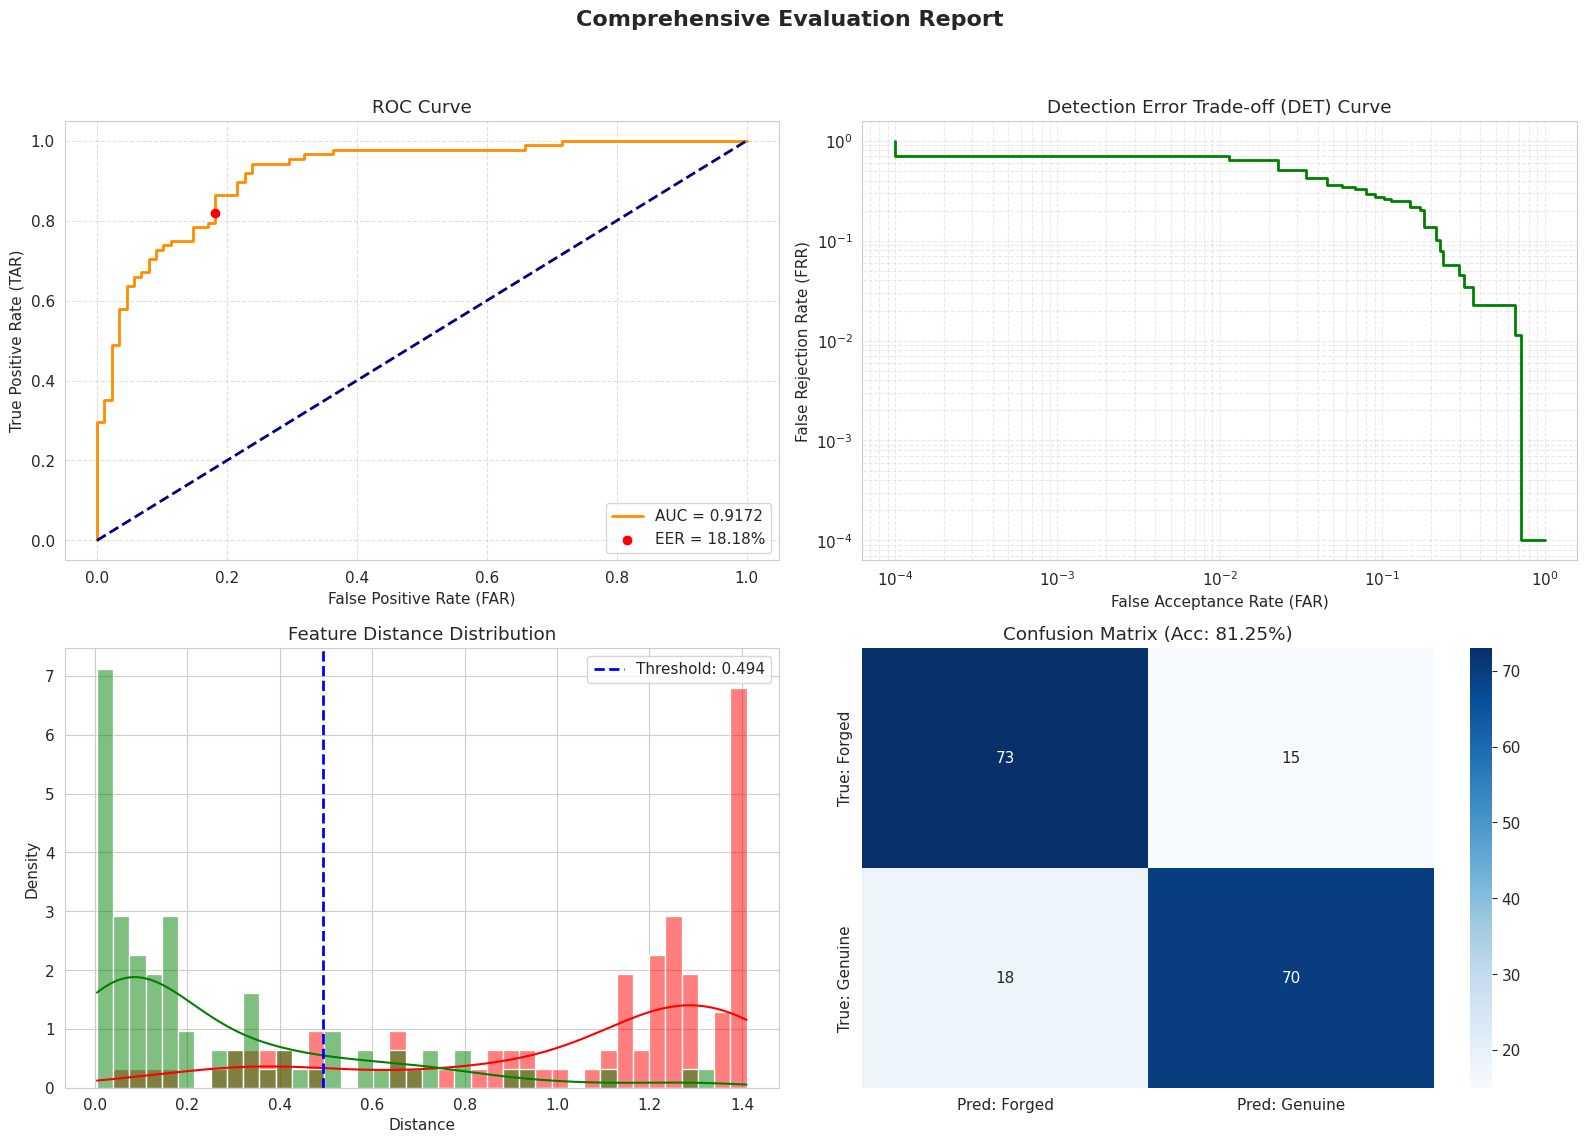

 > Visualizing Hard Examples (Mistakes)...

==================== QUALITATIVE ERROR ANALYSIS ====================
 > [Saved] Error analysis saved to: /kaggle/working/final_report_fold_1/error_analysis_false_accept.png


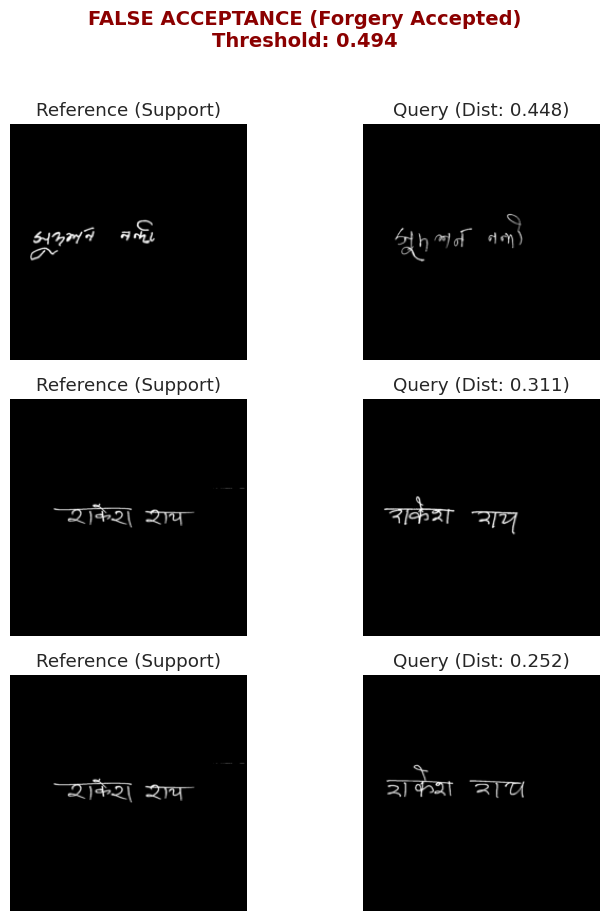

 > [Saved] Error analysis saved to: /kaggle/working/final_report_fold_1/error_analysis_false_reject.png


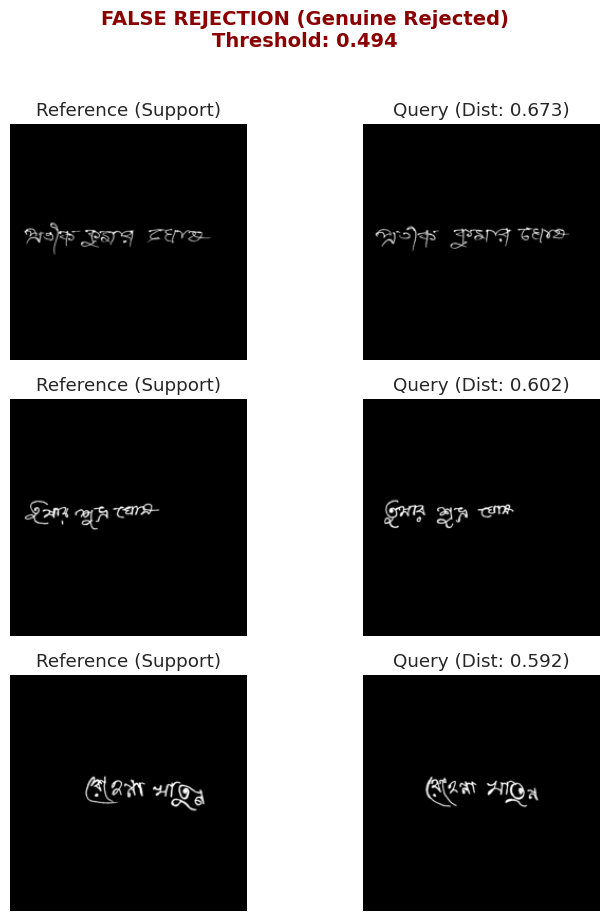


========================= REPORT GENERATED SUCCESSFULLY =========================
All analytical plots saved to: /kaggle/working/final_report_fold_1


In [6]:
# 1. IDENTIFY BEST PERFORMING FOLD
df = pd.DataFrame(fold_summary)
best_fold_idx = df['Accuracy (%)'].idxmax()
best_fold_row = df.loc[best_fold_idx]

print(f"\n{'='*20} FINAL REPORT: FOLD {best_fold_idx + 1} (BEST) {'='*20}")
print(f"Targeting Peak Performance: Accuracy {best_fold_row['Accuracy (%)']:.2f}%")

# 2. RELOAD BEST MODEL WEIGHTS
checkpoint_path = os.path.join(SAVE_DIR, f"bhsig_meta_fold_{best_fold_idx}_best.pth")
checkpoint = torch.load(checkpoint_path, map_location=DEVICE, weights_only=False)

feature_extractor = ResNetFeatureExtractor(pretrained=False).to(DEVICE)
metric_generator = MetricGenerator(embedding_dim=INPUT_DIM).to(DEVICE)
feature_extractor.load_state_dict(checkpoint['feature_extractor'])
metric_generator.load_state_dict(checkpoint['metric_generator'])

# 3. CONSTRUCT EVALUATION DATALOADER
split_file = os.path.join(SPLIT_DIR, f'bhsig_meta_split_fold_{best_fold_idx}.json')
val_set = SignatureEpisodeDataset(
    split_file, None, 'meta-test', 
    k_shot=K_SHOT, n_query_genuine=N_QUERY_GENUINE, n_query_forgery=N_QUERY_FORGERY, 
    augment=False, use_full_path=True
)
val_loader = DataLoader(val_set, batch_size=4, shuffle=False, num_workers=2)

# 4. QUANTITATIVE & QUALITATIVE ANALYSIS
# Generate Comprehensive Evaluation Dashboard
FINAL_REPORT_DIR = f'/kaggle/working/final_report_fold_{best_fold_idx+1}'
os.makedirs(FINAL_REPORT_DIR, exist_ok=True)

print(f" > Generating Performance Metrics Dashboard...")
final_metrics = evaluate_and_plot(
    feature_extractor, 
    metric_generator, 
    val_loader, 
    DEVICE, 
    save_dir=FINAL_REPORT_DIR
)

# Visualize Error Cases (Hard Negative/Positive Examples)
print(f" > Visualizing Hard Examples (Mistakes)...")
visualize_hard_examples(
    feature_extractor, 
    metric_generator, 
    val_loader, 
    DEVICE, 
    threshold=final_metrics['threshold'], 
    num_examples=3, 
    save_dir=FINAL_REPORT_DIR
)

print(f"\n{'='*25} REPORT GENERATED SUCCESSFULLY {'='*25}")
print(f"All analytical plots saved to: {FINAL_REPORT_DIR}")